# Deep Convolutional Generative Adversarial Network

In [3]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

In [5]:
attributes = pd.read_csv(r'C:\Users\ASUS\DL practice\archive (3)\list_attr_celeba.csv')
bboxes = pd.read_csv(r'C:\Users\ASUS\DL practice\archive (3)\list_bbox_celeba.csv')
partition = pd.read_csv(r'C:\Users\ASUS\DL practice\archive (3)\list_eval_partition.csv')
landmarks = pd.read_csv(r'C:\Users\ASUS\DL practice\archive (3)\list_landmarks_align_celeba.csv')
base_directory = 'C:\\Users\\ASUS\\DL practice\\archive (3)\\img_align_celeba\\img_align_celeba'
#base_directory = 'D:\GAN\GAN_Facedataset'

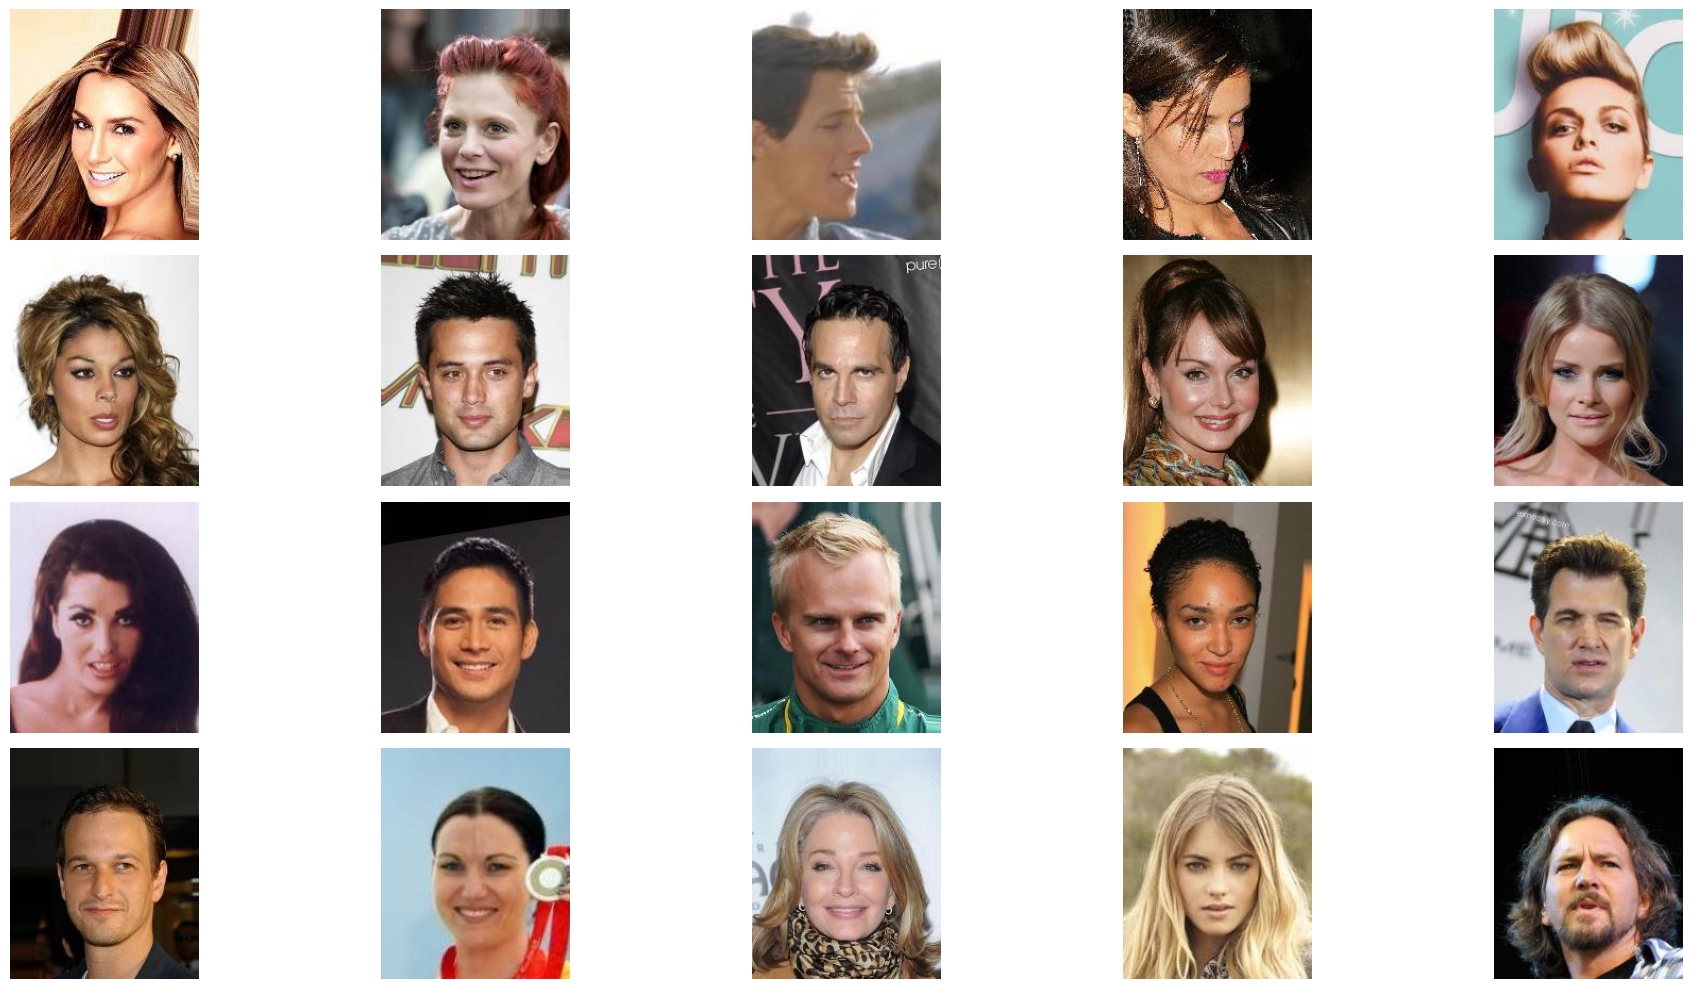

In [6]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math  # Import math for ceil
%matplotlib inline

images = []
for img_path in glob.glob(r'C:\Users\ASUS\DL practice\archive (3)\img_align_celeba\img_align_celeba\*.jpg'):
    images.append(mpimg.imread(img_path))

# Limit to first 20 images
images = images[:20]

# Plot images
plt.figure(figsize=(20, 10))
columns = 5
rows = math.ceil(len(images) / columns)  # Ensure rows is an integer
for i, image in enumerate(images):
    plt.subplot(rows, columns, i + 1)
    plt.axis('off')
    plt.imshow(image)

plt.tight_layout()
plt.show()


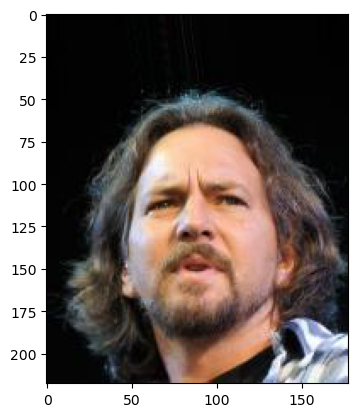

In [7]:
    plt.imshow(image)

# Reading list_landmarks_align_celeba.csv

In [9]:
landmarks

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150
...,...,...,...,...,...,...,...,...,...,...,...
105,162280.jpg,71,113,108,109,104,128,70,156,103,150
106,162281.jpg,71,111,107,110,90,139,72,152,104,155
107,162282.jpg,72,111,106,110,82,134,73,154,102,154
108,162283.jpg,70,111,107,111,88,141,75,152,102,153


# Plotting Landmarks

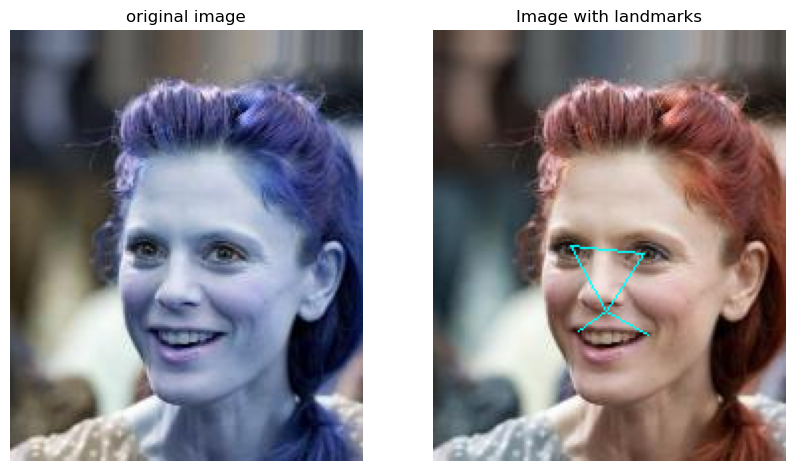

In [11]:
paths_to_images = 'C:\\Users\\ASUS\\DL practice\\archive (3)\\img_align_celeba\\img_align_celeba\\000002.jpg'


#current_landmarks = landmarks.query('image_id == "{}"'.format(paths_to_images.split('\\')[-1]))
#print("Current landmark ; ",current_landmarks)


eye_x, eye_y, eye_w, eye_h = np.array(landmarks.iloc[:, 1:5])[0]
nose_x,	nose_y,	leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y = np.array(landmarks.iloc[:, 5:])[0]

left_eye = (eye_x, eye_y)
right_eye = (eye_w, eye_h)
nose = (nose_x + 10,nose_y)
left_mounth = (leftmouth_x, leftmouth_y)
right_mounth = (rightmouth_x, rightmouth_y)

example_image = cv2.imread(paths_to_images)
original_image = example_image.copy()


example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)#############

example_image = cv2.line(example_image, left_eye, right_eye, (0, 255, 255),1)
example_image = cv2.line(example_image, left_eye, nose, (0, 255, 255), 1)
example_image = cv2.line(example_image, right_eye, nose, (0, 255, 255), 1)
example_image = cv2.line(example_image, nose, left_mounth,(0, 255, 255), 1)
example_image = cv2.line(example_image, nose, right_mounth, (0, 255, 255), 1)

plt.figure(figsize = (10, 20))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('original image')
plt.imshow(original_image)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Image with landmarks')
plt.imshow(example_image)

In [12]:
# Reading Bounding Box coordinates list_bbox_celeba.csv

In [13]:
bboxes

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166
...,...,...,...,...,...
106,162781.jpg,808,110,343,475
107,162782.jpg,65,21,294,407
108,162783.jpg,66,81,198,274
109,162784.jpg,173,53,122,169


# Plotting Bounding Box Cordinates

     image_id  x_1  y_1  width  height
1  000002.jpg   72   94    221     306


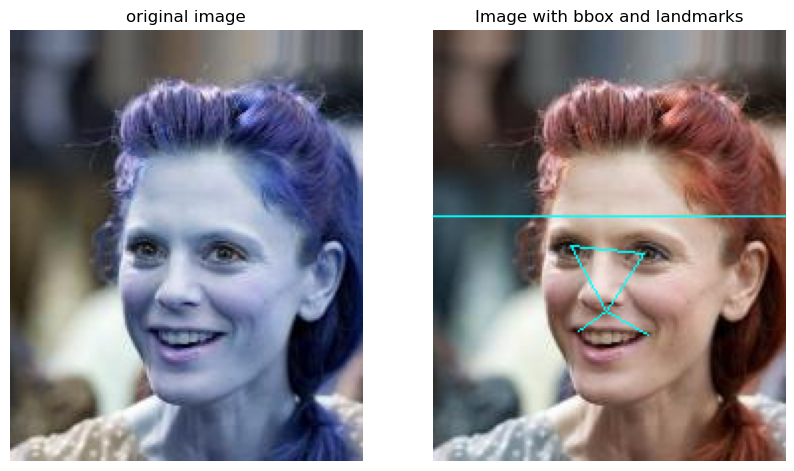

In [15]:
current_bbox = bboxes.query('image_id == "{}"'.format(paths_to_images.split('\\')[-1]))
print(current_bbox)
x, y, w, h = np.array(current_bbox.iloc[:, 1:])[0]

example_image = cv2.rectangle(example_image, (x - w, y ), (w , h ), (0, 255, 255), 1)###############

plt.figure(figsize = (10, 20))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('original image')
plt.imshow(original_image)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Image with bbox and landmarks')
plt.imshow(example_image)

In [16]:
# Reading list_eval_partition.csv

In [17]:
partition

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
105,162780.jpg,1
106,162781.jpg,1
107,162782.jpg,1
108,162783.jpg,1


# Types of Partitions

In [19]:
partition['partition'].value_counts()
# Have 3 partitions  (partition is just recomended parameter of dataset distribution)

partition
0    65
2    31
1    14
Name: count, dtype: int64

In [20]:
train_images = partition.query('partition == 0')
valid_images = partition.query('partition == 1')
test_images = partition.query('partition == 2')

In [21]:
# Reading list_attr_celeba.csv

In [22]:
attributes

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,162780.jpg,-1,-1,1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
106,162781.jpg,-1,-1,1,-1,-1,1,1,-1,-1,...,-1,-1,1,-1,-1,-1,1,-1,-1,1
107,162782.jpg,-1,-1,-1,1,-1,1,1,-1,-1,...,-1,1,-1,1,-1,-1,1,1,-1,-1
108,162783.jpg,-1,-1,-1,1,-1,-1,-1,-1,1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,1


# Create the discriminator

It maps a 64x64 image to a binary classification score.

After receiving all the images, fake and real, the Discriminator returns probabilities, a number in the range of 0 and 1, 1 representing a prediction of authenticity and 0 representing fake

The research shows that image generation is possible with relatively low input quality (64x64 pixels)

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),# 64 is filter number
        # thus down-sampling to 32,32,64
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),# 128 filter
           # thus down-sampling to 16,16,128
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
         # thus down-sampling to 8,8,128
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),# 8192===8x8x128 mileee
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),###
    ],
    name="discriminator",
)
discriminator.summary()

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

# Generator

In [27]:
# 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 100# 1D vector 100x1===Random noise

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),#######
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # Conv2DTranspose for upsamling
        # 16,16,128
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
         # Conv2DTranspose for upsamling
        # 32,32,256
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
           # Conv2DTranspose for upsamling
        # 64,64,512
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
        #64,64,3
    ],
    name="generator",
)
generator.summary()

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │       827,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,750,275 (14.31 MB)

 Trainable params: 3,750,275 (14.31 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\ASUS\\DL practice\\archive (3)\\img_align_celeba\\img_align_celeba", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 139 files.


# Override train_step

In [30]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim # 1D vector 100x1===Random noise


    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer#####
        self.g_optimizer = g_optimizer#####
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
## real image=== amader dataset ta
    def train_step(self, real_images):########################################################
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))# picking up the random noise

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)## random_latent_vector

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # **Train the discriminator**
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

# Create a callback that periodically saves generated images

In [32]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))
            plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
            plt.show()

# Train the end-to-end model

Adam optimizer with a learning rate of 0.002. This is as per the original research paper on DCGANs. Link: https://arxiv.org/abs/1511.06434

In [35]:
epochs = 50  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
    #GANMonitor for storing the fake images
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.6811 - g_loss: 0.7982

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - d_loss: 0.6794 - g_loss: 0.8029
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.6382 - g_loss: 0.9027

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - d_loss: 0.6371 - g_loss: 0.9034
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.5960 - g_loss: 0.8878

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.5953 - g_loss: 0.8870
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.5732 - g_loss: 0.8841

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - d_loss: 0.5728 - g_loss: 0.8842
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.5842 - g_loss: 0.8335

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - d_loss: 0.5865 - g_loss: 0.8290
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.5989 - g_loss: 0.7582

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.5956 - g_loss: 0.7612
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.4692 - g_loss: 0.9257

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.4650 - g_loss: 0.9356
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.3287 - g_loss: 1.1992

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - d_loss: 0.3255 - g_loss: 1.2106
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.2512 - g_loss: 1.4659

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.2480 - g_loss: 1.4706
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.2210 - g_loss: 1.5646

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.2231 - g_loss: 1.5563
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.3364 - g_loss: 1.1650

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.3534 - g_loss: 1.1343
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.7516 - g_loss: 0.4057

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.7653 - g_loss: 0.4082
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.9490 - g_loss: 0.5069

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - d_loss: 0.9411 - g_loss: 0.5099
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.7104 - g_loss: 0.8133

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.7128 - g_loss: 0.8144
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.6379 - g_loss: 0.8546

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.6301 - g_loss: 0.8708
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.5335 - g_loss: 1.2567

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - d_loss: 0.5390 - g_loss: 1.2407
Epoch 17/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.5255 - g_loss: 1.0771

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.5159 - g_loss: 1.0934
Epoch 18/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.3788 - g_loss: 1.5729

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.3692 - g_loss: 1.5830
Epoch 19/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.2585 - g_loss: 1.9466

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.2540 - g_loss: 1.9585
Epoch 20/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.1521 - g_loss: 2.4792

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.1575 - g_loss: 2.4917
Epoch 21/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.1254 - g_loss: 2.6034

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - d_loss: 0.1238 - g_loss: 2.6188
Epoch 22/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.0959 - g_loss: 3.5286

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.0944 - g_loss: 3.5496
Epoch 23/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.0718 - g_loss: 4.0345

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - d_loss: 0.0713 - g_loss: 4.0281
Epoch 24/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.0889 - g_loss: 3.8970

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - d_loss: 0.0894 - g_loss: 3.8830
Epoch 25/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.1225 - g_loss: 2.9075

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.1246 - g_loss: 2.8866
Epoch 26/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.1610 - g_loss: 3.0560

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - d_loss: 0.1667 - g_loss: 2.9776
Epoch 27/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.2064 - g_loss: 2.6569

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.2091 - g_loss: 2.6643
Epoch 28/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.2632 - g_loss: 2.1758

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.2832 - g_loss: 2.1924
Epoch 29/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.5335 - g_loss: 2.1701

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.5395 - g_loss: 2.1536
Epoch 30/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.6767 - g_loss: 1.6342

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.6751 - g_loss: 1.6385
Epoch 31/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.4463 - g_loss: 1.3916

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.4463 - g_loss: 1.3973
Epoch 32/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.4627 - g_loss: 1.9436

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.4646 - g_loss: 1.9190
Epoch 33/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.9138 - g_loss: 0.9736

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.9387 - g_loss: 0.9391
Epoch 34/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.6714 - g_loss: 0.3616

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 1.6557 - g_loss: 0.3524
Epoch 35/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 1.2112 - g_loss: 0.3381

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - d_loss: 1.1996 - g_loss: 0.3410
Epoch 36/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.7920 - g_loss: 0.5409

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - d_loss: 0.7798 - g_loss: 0.5491
Epoch 37/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.5277 - g_loss: 0.8769

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - d_loss: 0.5246 - g_loss: 0.8788
Epoch 38/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.4817 - g_loss: 1.1098

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.4820 - g_loss: 1.1106
Epoch 39/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.3909 - g_loss: 1.1707

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - d_loss: 0.3928 - g_loss: 1.1648
Epoch 40/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.3798 - g_loss: 1.1043

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.3766 - g_loss: 1.1087
Epoch 41/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.4069 - g_loss: 1.1393

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.4081 - g_loss: 1.1334
Epoch 42/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.4471 - g_loss: 1.0645

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - d_loss: 0.4455 - g_loss: 1.0663
Epoch 43/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.4720 - g_loss: 1.2188

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - d_loss: 0.4675 - g_loss: 1.2082
Epoch 44/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.4253 - g_loss: 0.9108

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - d_loss: 0.4305 - g_loss: 0.9035
Epoch 45/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.4750 - g_loss: 0.9542

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.4754 - g_loss: 0.9532
Epoch 46/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.4929 - g_loss: 0.9416

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - d_loss: 0.4910 - g_loss: 0.9417
Epoch 47/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.4942 - g_loss: 1.0970

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - d_loss: 0.4887 - g_loss: 1.0862
Epoch 48/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.4148 - g_loss: 1.1100

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - d_loss: 0.4136 - g_loss: 1.1009
Epoch 49/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.3478 - g_loss: 1.0701

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - d_loss: 0.3472 - g_loss: 1.0789
Epoch 50/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.3070 - g_loss: 1.2028

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - d_loss: 0.3071 - g_loss: 1.2069


In [36]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [37]:
import glob
print(glob.glob(r'C:\Users\ASUS\DL practice\*.png'))


['C:\\Users\\ASUS\\DL practice\\generated_img_000_0.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_000_1.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_000_2.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_000_3.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_000_4.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_000_5.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_000_6.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_000_7.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_000_8.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_000_9.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_001_0.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_001_1.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_001_2.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_001_3.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_001_4.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_001_5.png', 'C:\\Users\\ASUS\\DL practice\\generated_img_001_6.png', 'C:\\Users\\ASUS\\DL practice\

C:\Users\ASUS\AppData\Local\Temp\ipykernel_34324\3807422642.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()  # Ensure spacing between subplots is managed


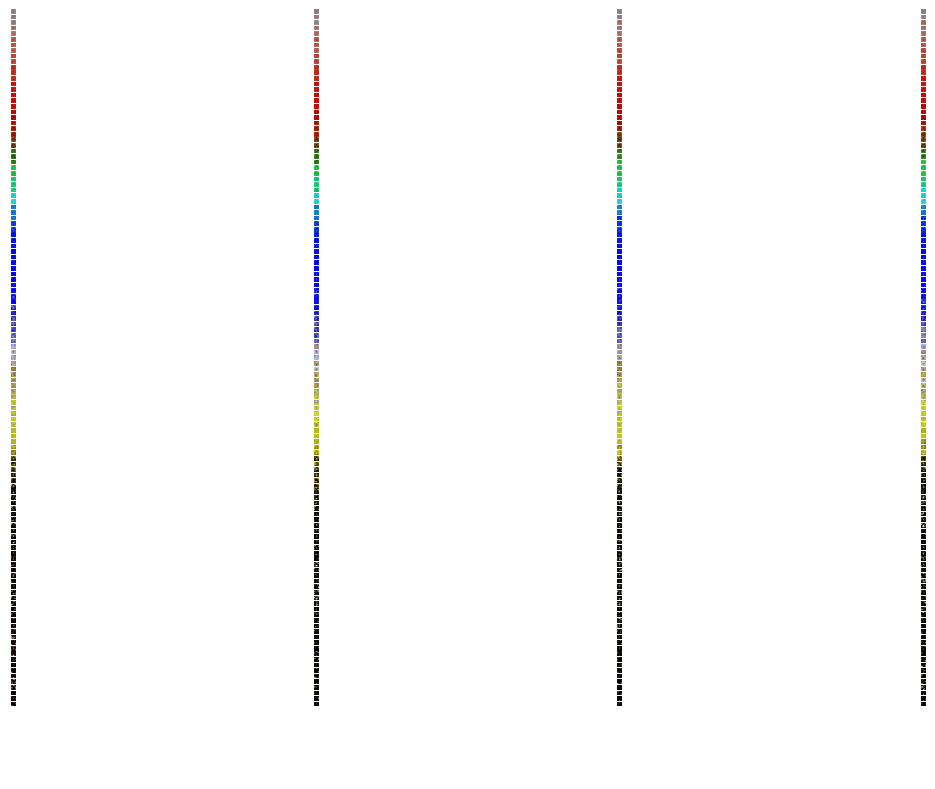

In [38]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math  # Import math for ceil
%matplotlib inline

# Load images
images = []
for img_path in glob.glob(r'C:\Users\ASUS\DL practice\*.png'):
    images.append(mpimg.imread(img_path))

# Check if images were loaded
if not images:
    print("No images found in the specified directory.")
else:
    # Plot images
    plt.figure(figsize=(15, 10))  # Adjust figsize for larger subplots
    columns = 4  # Use fewer columns to increase the size of each image
    rows = math.ceil(len(images) / columns)  # Calculate rows

    for i, image in enumerate(images):
        plt.subplot(rows, columns, i + 1)
        plt.axis('off')  # Turn off axes for cleaner visualization
        plt.imshow(image)

    plt.tight_layout()  # Ensure spacing between subplots is managed
    plt.show()
